In [1]:
# set notebook defaults
%load_ext autoreload
%autoreload 2

from IPython.display import display, clear_output

def display_tables(*args):
    clear_output()
    display(*args)

**Preprocessing: drop outliers + scale pain signature responses + filter missing data**

In [2]:
import fig02to04S1 as src
import pandas as pd

pd.set_option("display.float_format", "{:.4f}".format)


id_cols = ["sub", "group", "study", "age", "gender"]
task_cols = ["sub", "task", "group", "study", "age", "gender"]
vas_cols, psr_cols = ["int", "unp"], ["nps", "na", "siips"]

# study1: blood oxygen level dependent imaging
bold = (
    pd.read_csv("../data/bold-ps-agg.csv")
    .merge(pd.read_csv("../config/bold-dem.csv"), on="sub")
    .assign(study="bold")
    .pipe(src.scale, psr_cols)  # zscore by study
)

# study2: cerebral blood flow imaging
cbf = (
    pd.read_csv("../data/cbf-ps-agg.csv")
    .merge(pd.read_csv("../config/cbf-dem.csv"), on="sub")
    .assign(study="cbf")
    .query("task.str.endswith('49C') and cbfQEI > 0.36")  # select CBF quality index > 36% = 1.5 IQR
    .pipe(src.scale, psr_cols)  # zscore by study
)

# study1 + study2: pain signature responses
psr = (
    pd.concat([bold[task_cols + vas_cols + psr_cols], cbf[task_cols + vas_cols + psr_cols]])
    .groupby("sub")  # filter missing pre/post data
    .filter(lambda df: {"preManip49C", "postManip49C"}.issubset(df["task"]))
)

# study1 + study2: pain signature response differences
psr_diff = (
    psr.query("task.isin(['preManip49C', 'postManip49C'])")
    .pivot_table(index=id_cols, columns="task", values=vas_cols + psr_cols, aggfunc="mean")
    .pipe(
        lambda df: (df.xs("postManip49C", axis=1, level=1) - df.xs("preManip49C", axis=1, level=1))
    )
    .reset_index()
)

psr.groupby(["group", "study"])["sub"].nunique()

group  study
c      bold     20
       cbf      19
l      cbf      19
m      bold     20
       cbf      17
s      cbf      20
Name: sub, dtype: int64

**Figures 02-04 + S01: pain signature responses, vas pain ratings**

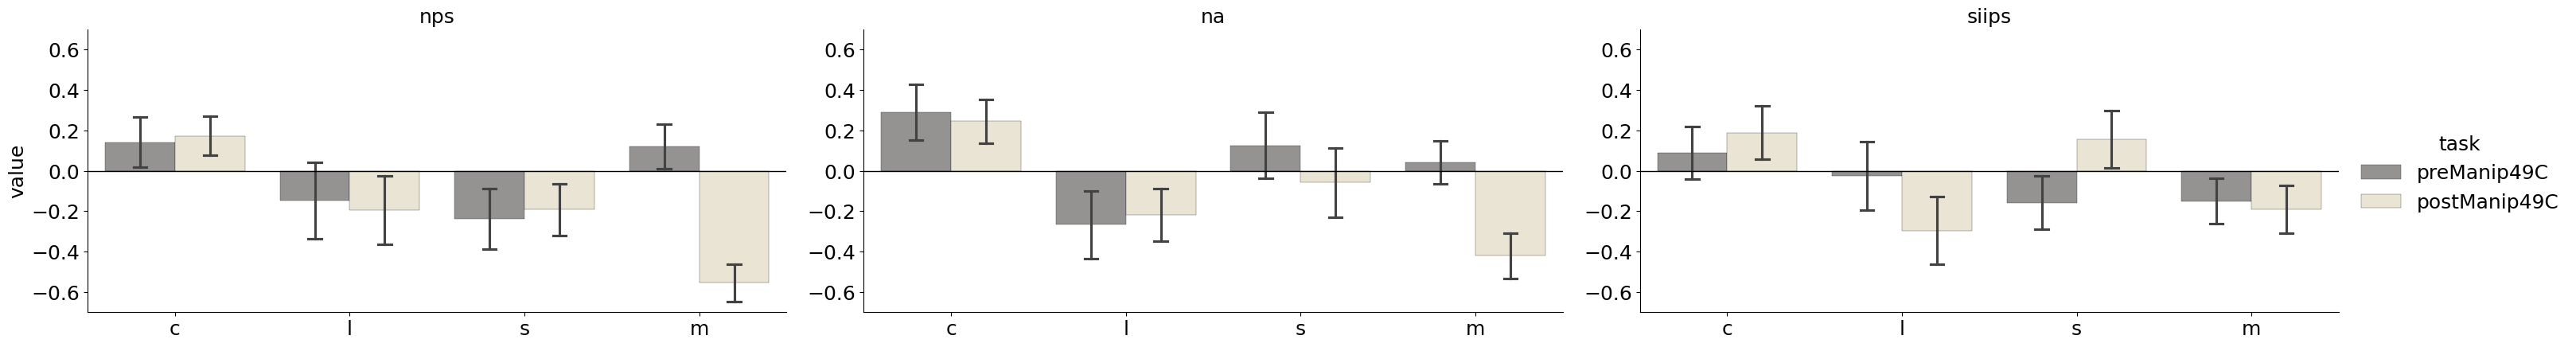

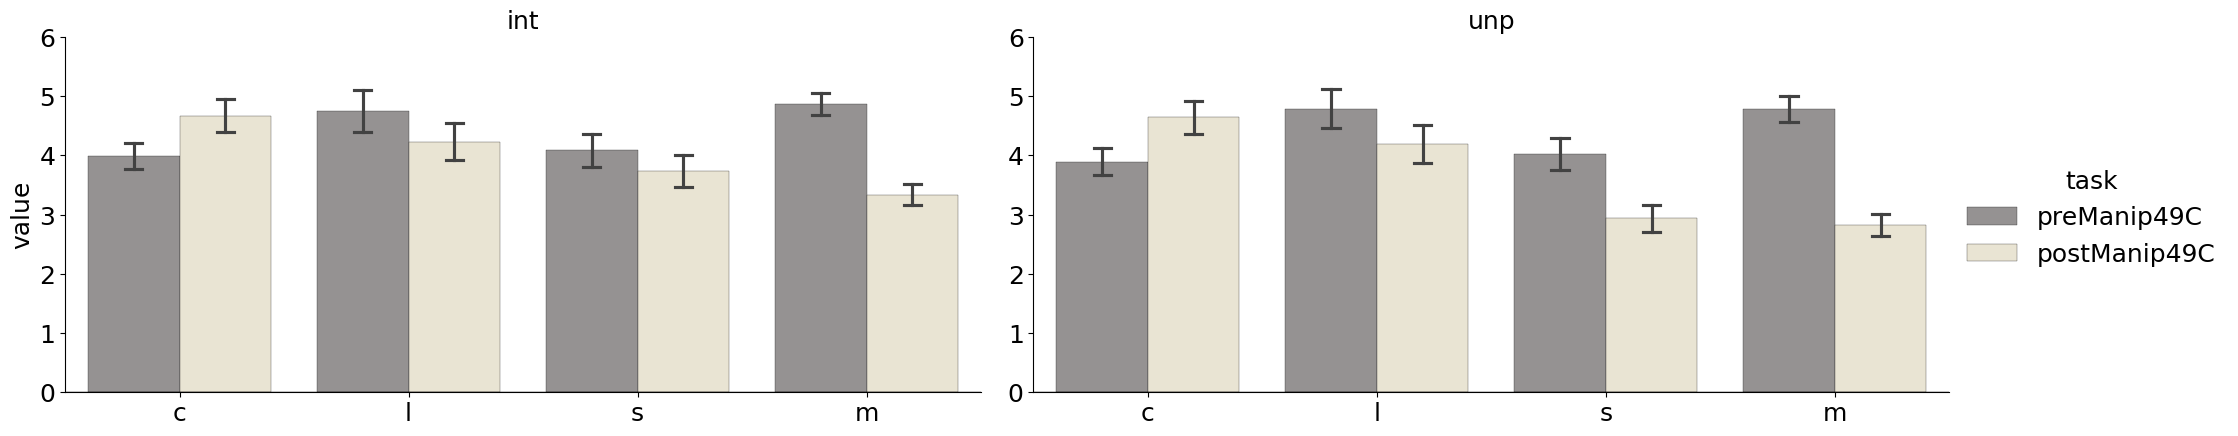

In [3]:
tasks, groups = ["preManip49C", "postManip49C"], ["c", "l", "s", "m"]


src.plot_group_by_manipulation(
    psr.query("task.isin(@tasks)").melt(id_vars=task_cols, value_vars=psr_cols),
    var_order=psr_cols,
    task_order=tasks,
    group_order=groups,
    ylim=(-0.7, +0.7),
).savefig("../figures/fig02to04-psr.png", dpi=600)

src.plot_group_by_manipulation(
    psr.query("task.isin(@tasks)").melt(id_vars=task_cols, value_vars=vas_cols),
    var_order=vas_cols,
    task_order=tasks,
    group_order=groups,
    ylim=(0, 6),
).savefig("../figures/figS01-vas.png", dpi=600)

**Tables S01-S03: vas pain ratings**

In [4]:
tasks, groups = ["postManip49C", "preManip49C", "baseline49C"], ["c", "l", "s", "m"]

tabS01 = (
    psr.groupby(["task", "group"])[vas_cols].agg(["mean", "std"]).reindex(tasks[::-1], level="task")
)

tabS02toS03 = psr.query("task.isin(@tasks) and group.isin(@groups)").melt(
    id_vars=task_cols, value_vars=vas_cols
)

tabS02toS03a = tabS02toS03.groupby("variable").apply(
    src.anova_table,
    formula="value ~ group * task * gender + (1 | sub) + (1 | study)",
    tasks=tasks,
    groups=groups,
)

tabS02toS03b = tabS02toS03.groupby("variable").apply(
    src.paired_ttests,
    formula="value ~ group * task * gender + (1 | sub) + (1 | study)",
    tasks=tasks,
    groups=groups,
)

tabS02toS03c = (
    psr_diff.melt(id_vars=id_cols, value_vars=vas_cols)
    .groupby("variable")
    .apply(src.unpaired_ttests, formula="value ~ group + gender + (1 | study)", groups=groups)
)

display_tables(tabS01, tabS02toS03a, tabS02toS03b, tabS02toS03c)
tabS01.to_csv("../results/tabS01-vas.csv")
tabS02toS03a.to_csv("../results/tabS02toS03a-psr.csv")
tabS02toS03b.to_csv("../results/tabS02toS03b-psr.csv")
tabS02toS03c.to_csv("../results/tabS02toS03c-psr.csv")

int           unp       
                     mean    std   mean    std
task         group                            
baseline49C  c     4.7216 2.2166 4.9440 2.4181
             l     4.6212 2.1876 5.0000 2.2783
             m     4.9377 1.9735 4.9974 2.3467
             s     4.5231 2.3957 4.6795 2.5582
preManip49C  c     3.9897 1.9715 3.8949 2.0601
             l     4.7568 2.1539 4.7865 2.0146
             m     4.8635 1.5880 4.7824 1.9438
             s     4.0825 1.7134 4.0250 1.7475
postManip49C c     4.6727 2.4168 4.6434 2.4611
             l     4.2316 1.9134 4.1895 1.9867
             m     3.3329 1.4842 2.8200 1.5790
             s     3.7333 1.6795 2.9359 1.4053

SS      MS  NumDF  DenomDF  F-stat  P-val  \
variable                                                                     
int      group               0.9162  0.3054      3 115.3225  0.2271 0.8774   
         task               44.0613 22.0306      2 641.2189 16.3838 0.0000   
         gender              0.9488  0.9488      1 115.6013  0.7056 0.4026   
         group:task        101.5028 16.9171      6 641.1531 12.5809 0.0000   
         group:gender        1.7112  0.5704      3 115.3225  0.4242 0.7360   
         task:gender         5.8769  2.9384      2 641.2189  2.1853 0.1133   
         group:task:gender  15.5945  2.5991      6 641.1531  1.9329 0.0733   
unp      group               4.0859  1.3620      3 115.9517  0.8091 0.4913   
         task              145.8277 72.9138      2 641.0334 43.3138 0.0000   
         gender              3.6326  3.6326      1 116.2679  2.1579 0.1445   
         group:task        151.2305 25.2051      6 640.9672 14.9729 0.0000   
         group:gender        1.5133  0.5044      3 115.9517  0.2997 0.8256   
         task:gender         6.3721  3.1861      2 641.0334  1.8926 0.1515   
         group:task:gender  10.8410  1.8068      6 640.9672  1.0733 0.3770   

                            Sig  
variable                         
int      group                   
         task               ***  
         gender                  
         group:task         ***  
         group:gender            
         task:gender             
         group:task:gender    .  
unp      group                   
         task               ***  
         gender                  
         group:task         ***  
         group:gender            
         task:gender             
         group:task:gender

Contrast group  Estimate  2.5_ci  97.5_ci  \
variable                                                                   
int      1   postManip49C - preManip49C     c    0.6750  0.3090   1.0420   
         4   postManip49C - preManip49C     l   -0.5290 -1.0560  -0.0020   
         7   postManip49C - preManip49C     s   -0.3510 -0.8640   0.1620   
         10  postManip49C - preManip49C     m   -1.4940 -1.8750  -1.1130   
unp      1   postManip49C - preManip49C     c    0.7330  0.3220   1.1450   
         4   postManip49C - preManip49C     l   -0.6080 -1.1980  -0.0180   
         7   postManip49C - preManip49C     s   -1.0810 -1.6550  -0.5070   
         10  postManip49C - preManip49C     m   -1.9320 -2.3580  -1.5060   

                SE       DF  T-stat  P-val  P-fdr  Sig  
variable                                                
int      1  0.1860 639.5850  3.6210 0.0000 0.0000  ***  
         4  0.2680 639.7100 -1.9730 0.0490 0.0653       
         7  0.2610 639.7160 -1.3420 0.1800 0.1800       
         10 0.1940 640.0200 -7.7060 0.0000 0.0000  ***  
unp      1  0.2090 639.5220  3.5000 0.0000 0.0000  ***  
         4  0.3000 639.2780 -2.0250 0.0430 0.0430    *  
         7  0.2920 639.2840 -3.6980 0.0000 0.0000  ***  
         10 0.2170 639.6360 -8.9060 0.0000 0.0000  ***

Contrast  Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  \
variable                                                                        
int      1    c - l    1.2200  0.5770   1.8630 0.3240 115.0000  3.7610 0.0000   
         2    c - s    1.0130  0.3820   1.6450 0.3190 115.0000  3.1790 0.0020   
         3    c - m    2.1380  1.6110   2.6660 0.2660 115.0000  8.0360 0.0000   
         4    l - s   -0.2070 -0.9420   0.5290 0.3710 115.0000 -0.5560 0.5790   
         5    l - m    0.9180  0.2700   1.5670 0.3270 115.0000  2.8070 0.0060   
         6    s - m    1.1250  0.4880   1.7620 0.3220 115.0000  3.4970 0.0010   
unp      1    c - l    1.3600  0.5490   2.1710 0.4090 115.0000  3.3230 0.0010   
         2    c - s    1.8130  1.0160   2.6090 0.4020 115.0000  4.5070 0.0000   
         3    c - m    2.6400  1.9750   3.3040 0.3360 115.0000  7.8630 0.0000   
         4    l - s    0.4530 -0.4750   1.3810 0.4690 115.0000  0.9670 0.3360   
         5    l - m    1.2800  0.4620   2.0970 0.4130 115.0000  3.1000 0.0020   
         6    s - m    0.8270  0.0230   1.6310 0.4060 115.0000  2.0370 0.0440   

            P-fdr  Sig  
variable                
int      1 0.0000  ***  
         2 0.0030   **  
         3 0.0000  ***  
         4 0.5790       
         5 0.0072   **  
         6 0.0020   **  
unp      1 0.0020   **  
         2 0.0000  ***  
         3 0.0000  ***  
         4 0.3360       
         5 0.0030   **  
         6 0.0528

**Tables S04-S05: pain signature responses**

In [5]:
tasks, groups = ["postManip49C", "preManip49C"], ["c", "l", "s", "m"]

tabS04toS06 = psr.query("task.isin(@tasks) and group.isin(@groups)").melt(
    id_vars=task_cols, value_vars=psr_cols
)

tabS04toS06a = (
    tabS04toS06.groupby("variable")
    .apply(
        src.anova_table,
        formula="value ~ group * task * gender + (1 | sub) + (1 | study)",
        tasks=tasks,
        groups=groups,
    )
    .reindex(psr_cols, level="variable")
)

tabS04toS06b = (
    tabS04toS06.groupby("variable")
    .apply(
        src.paired_ttests,
        formula="value ~ group * task * gender + (1 | sub) + (1 | study)",
        tasks=tasks,
        groups=groups,
    )
    .reindex(psr_cols, level="variable")
)

tabS04toS06c = (
    psr_diff.melt(id_vars=id_cols, value_vars=psr_cols)
    .groupby("variable")
    .apply(src.unpaired_ttests, formula="value ~ group + gender + (1 | study)", groups=groups)
    .reindex(psr_cols, level="variable")
)

display_tables(tabS04toS06a, tabS04toS06b, tabS04toS06c)
tabS04toS06a.to_csv("../results/tabS04toS06a-psr.csv")
tabS04toS06b.to_csv("../results/tabS04toS06b-psr.csv")
tabS04toS06c.to_csv("../results/tabS04toS06c-psr.csv")

SS     MS  NumDF  DenomDF  F-stat  P-val  Sig
variable                                                                     
nps      group              1.8034 0.6011      3 114.7794  1.8742 0.1379     
         task               3.1852 3.1852      1 338.2959  9.9308 0.0018   **
         gender             0.4973 0.4973      1 114.7618  1.5504 0.2156     
         group:task        11.2086 3.7362      3 338.3107 11.6487 0.0000  ***
         group:gender       0.3667 0.1222      3 114.7794  0.3811 0.7668     
         task:gender        0.4795 0.4795      1 338.2959  1.4950 0.2223     
         group:task:gender  1.8094 0.6031      3 338.3107  1.8804 0.1326     
na       group              2.3723 0.7908      3 115.0986  2.4283 0.0690    .
         task               3.1288 3.1288      1 338.5392  9.6078 0.0021   **
         gender             0.7037 0.7037      1 115.0830  2.1611 0.1443     
         group:task         4.5796 1.5265      3 338.5522  4.6877 0.0032   **
         group:gender       0.5000 0.1667      3 115.0986  0.5118 0.6749     
         task:gender        0.6921 0.6921      1 338.5392  2.1252 0.1458     
         group:task:gender  1.4309 0.4770      3 338.5522  1.4647 0.2240     
siips    group              0.6485 0.2162      3 114.9072  0.8969 0.4451     
         task               0.1487 0.1487      1 338.2020  0.6169 0.4328     
         gender             0.6261 0.6261      1 114.8966  2.5981 0.1097     
         group:task         3.7084 1.2361      3 338.2108  5.1294 0.0018   **
         group:gender       0.4906 0.1635      3 114.9072  0.6786 0.5669     
         task:gender        0.2723 0.2723      1 338.2020  1.1301 0.2885     
         group:task:gender  0.3019 0.1006      3 338.2108  0.4175 0.7405

Contrast group  Estimate  2.5_ci  97.5_ci  \
variable                                                                  
nps      1  postManip49C - preManip49C     c    0.0190 -0.1600   0.1990   
         2  postManip49C - preManip49C     l   -0.0570 -0.3150   0.2010   
         3  postManip49C - preManip49C     s    0.0060 -0.2460   0.2570   
         4  postManip49C - preManip49C     m   -0.6780 -0.8650  -0.4920   
na       1  postManip49C - preManip49C     c   -0.0550 -0.2360   0.1260   
         2  postManip49C - preManip49C     l    0.0320 -0.2280   0.2920   
         3  postManip49C - preManip49C     s   -0.2030 -0.4560   0.0500   
         4  postManip49C - preManip49C     m   -0.4780 -0.6660  -0.2900   
siips    1  postManip49C - preManip49C     c    0.0870 -0.0690   0.2420   
         2  postManip49C - preManip49C     l   -0.2590 -0.4820  -0.0350   
         3  postManip49C - preManip49C     s    0.3450  0.1280   0.5630   
         4  postManip49C - preManip49C     m   -0.0200 -0.1810   0.1420   

               SE       DF  T-stat  P-val  P-fdr  Sig  
variable                                               
nps      1 0.0910 338.0610  0.2120 0.8320 0.9660       
         2 0.1310 338.2290 -0.4320 0.6660 0.9660       
         3 0.1280 338.2510  0.0430 0.9660 0.9660       
         4 0.0950 338.7240 -7.1560 0.0000 0.0000  ***  
na       1 0.0920 338.3330 -0.5980 0.5500 0.7333       
         2 0.1320 338.4800  0.2440 0.8080 0.8080       
         3 0.1290 338.4990 -1.5780 0.1160 0.2320       
         4 0.0960 338.9140 -5.0050 0.0000 0.0000  ***  
siips    1 0.0790 338.0630  1.0970 0.2730 0.3640       
         2 0.1140 338.1620 -2.2770 0.0230 0.0460    *  
         3 0.1110 338.1750  3.1190 0.0020 0.0080   **  
         4 0.0820 338.4560 -0.2390 0.8110 0.8110

Contrast  Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  \
variable                                                                        
nps      1    c - l    0.0740 -0.3080   0.4570 0.1930 115.0000  0.3850 0.7010   
         2    c - s    0.0130 -0.3640   0.3890 0.1900 115.0000  0.0670 0.9470   
         3    c - m    0.6940  0.3800   1.0080 0.1590 115.0000  4.3770 0.0000   
         4    l - s   -0.0620 -0.5000   0.3770 0.2210 115.0000 -0.2790 0.7810   
         5    l - m    0.6200  0.2330   1.0060 0.1950 115.0000  3.1780 0.0020   
         6    s - m    0.6810  0.3020   1.0610 0.1920 115.0000  3.5540 0.0010   
na       1    c - l   -0.0660 -0.4490   0.3170 0.1940 115.0000 -0.3410 0.7340   
         2    c - s    0.1520 -0.2240   0.5290 0.1900 115.0000  0.8010 0.4250   
         3    c - m    0.4310  0.1160   0.7450 0.1590 115.0000  2.7140 0.0080   
         4    l - s    0.2180 -0.2210   0.6570 0.2220 115.0000  0.9850 0.3260   
         5    l - m    0.4970  0.1100   0.8830 0.1950 115.0000  2.5450 0.0120   
         6    s - m    0.2780 -0.1020   0.6590 0.1920 115.0000  1.4510 0.1500   
siips    1    c - l    0.4030  0.0460   0.7590 0.1790  82.2750  2.2470 0.0270   
         2    c - s   -0.2260 -0.5760   0.1250 0.1760  80.3120 -1.2790 0.2050   
         3    c - m    0.0730 -0.2080   0.3550 0.1420 111.8210  0.5140 0.6080   
         4    l - s   -0.6280 -1.0210  -0.2350 0.1980 111.6830 -3.1680 0.0020   
         5    l - m   -0.3300 -0.6900   0.0310 0.1810  77.2130 -1.8180 0.0730   
         6    s - m    0.2990 -0.0570   0.6540 0.1780  75.2230  1.6730 0.0990   

            P-fdr  Sig  
variable                
nps      1 0.9372       
         2 0.9470       
         3 0.0000  ***  
         4 0.9372       
         5 0.0040   **  
         6 0.0030   **  
na       1 0.7340       
         2 0.5100       
         3 0.0360    *  
         4 0.4890       
         5 0.0360    *  
         6 0.3000       
siips    1 0.0810       
         2 0.2460       
         3 0.6080       
         4 0.0120    *  
         5 0.1460       
         6 0.1485